In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "4772",
                            database = "ecommerce")

cur = db.cursor()

## List all unique cities where customers are located.

In [3]:
query = """ select distinct(customer_city) from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["City"])
df.head()

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total number of orders placed in 2017 are: ", data[0][0]

('Total number of orders placed in 2017 are: ', 45101)

## Find the total sales per category.

In [5]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


## Calculate the percentage of orders that were paid in installments.

In [6]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments

"""

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is: ", data

('The percentage of orders that were paid in installments is: ',
 [(Decimal('99.9981'),)])

## Count the number of customers from each state.

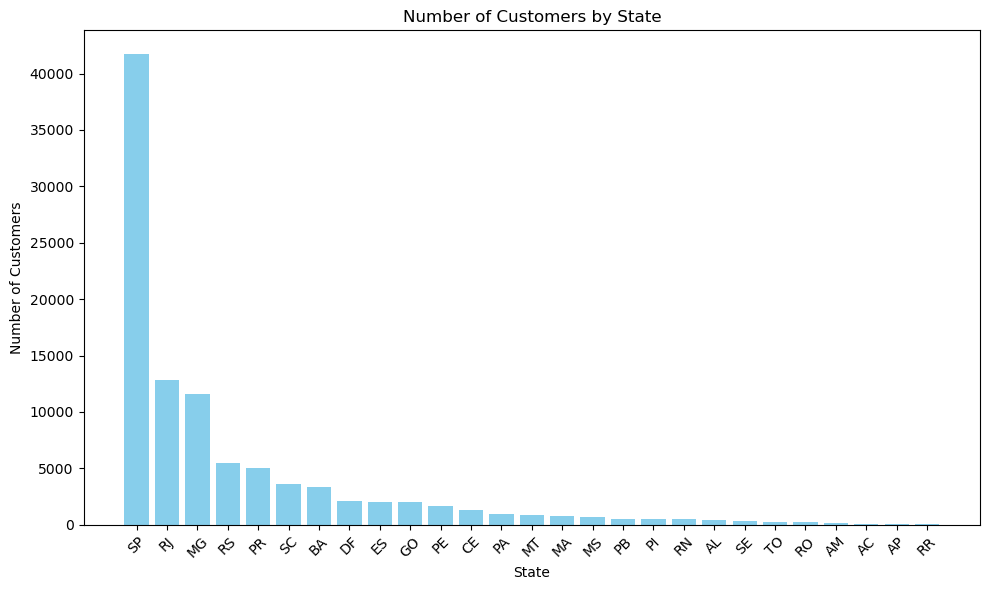

<Figure size 800x300 with 0 Axes>

In [7]:
query = """ select customer_state, count(customer_id) from customers 
group by customer_state

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["State", "No. of Customers"])
df = df.sort_values(by = "No. of Customers", ascending = False)

plt.figure(figsize=(10, 6))
plt.bar(x=df["State"], height=df["No. of Customers"], color='skyblue')

# Add labels and title
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by State')

# Rotate x-axis labels for better readability if there are many states
plt.xticks(rotation=45)

plt.tight_layout()
plt.figure(figsize = (8,3))
plt.show()

## Calculate the number of orders per month in 2018.

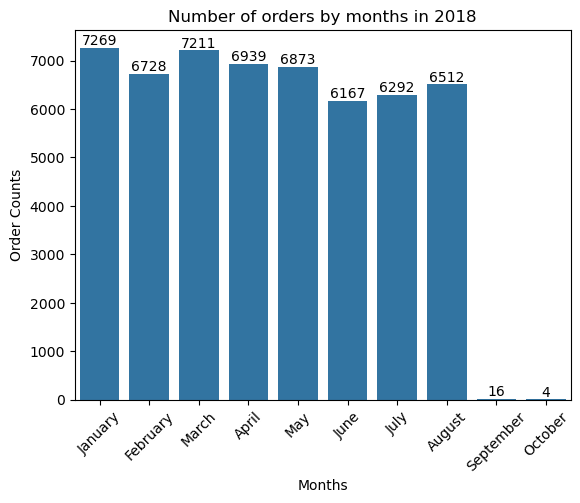

In [8]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Months", "Order Counts"])

o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(data = df, x  = df["Months"], y = df["Order Counts"], order = o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders by months in 2018")

plt.show()


## Find the average number of products per order, grouped by customer city.

In [9]:
query = """ WITH count_per_order AS (
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc), 2) AS avg_order_count
FROM customers 
JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city ORDER BY avg_order_count desc
;


"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer City", "Average Products/Order"])
df.head(10)

,Customer City,Average Products/Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


## Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """ select upper(products.product_category) category, 
    round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
    from products join order_items
    on products.product_id = order_items.product_id
    join payments
    on payments.order_id = order_items.order_id
    group by category order by sales_percentage desc;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Percentage Distribution"])
df.head(10)

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


## Identify the correlation between product price and the number of times a product has been purchased.

In [38]:
query = """ select products.product_category,
    count(order_items.product_id),
    round(avg(order_items.price),2)
    from products join order_items
    on products.product_id = order_items.product_id
    group by products.product_category;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Order Count", "Price"])

arr1 = df["Order Count"]
arr2 = df["Price"]

corr = np.corrcoef(arr1, arr2)

print("The correlation between product price and the number of times a product has been purchased is: ", corr[0][1])

The correlation between product price and the number of times a product has been purchased is:  -0.10631514167157562


## Calculate the total revenue generated by each seller, and rank them by revenue.

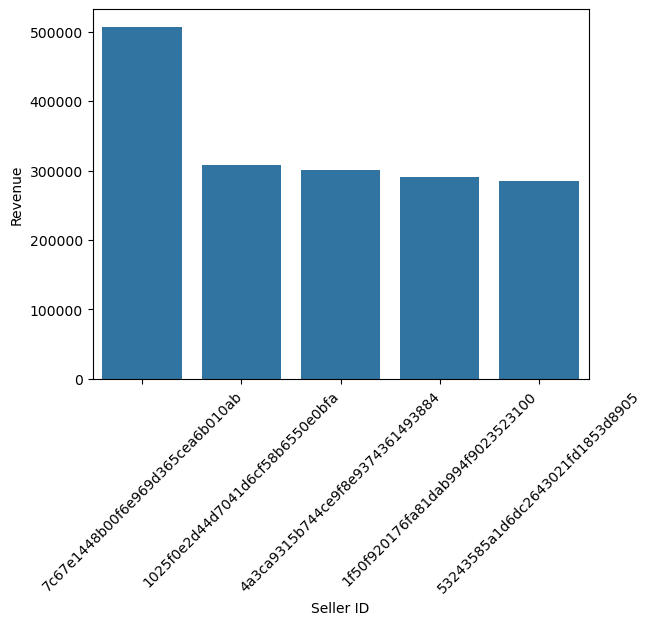

In [12]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) 
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Seller ID", "Revenue", "Rank"])

sns.barplot(x = "Seller ID", y = "Revenue", data = df.head())
plt.xticks(rotation=45)
plt.show()

## Calculate the moving average of order values for each customer over their order history.

In [37]:
query = """ SELECT customer_id, 
       order_purchase_timestamp, 
       payment, 
       AVG(payment) OVER (PARTITION BY customer_id 
                          ORDER BY order_purchase_timestamp 
                          ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS mov_avg
FROM (
    SELECT orders.customer_id, 
           orders.order_purchase_timestamp,
           payments.payment_value AS payment
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
) AS a;
;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer ID", "Order Purchase Timestamp", "Payment", "Moving Average"])
df.head()

,Customer ID,Order Purchase Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


## Calculate the cumulative sales per month for each year.

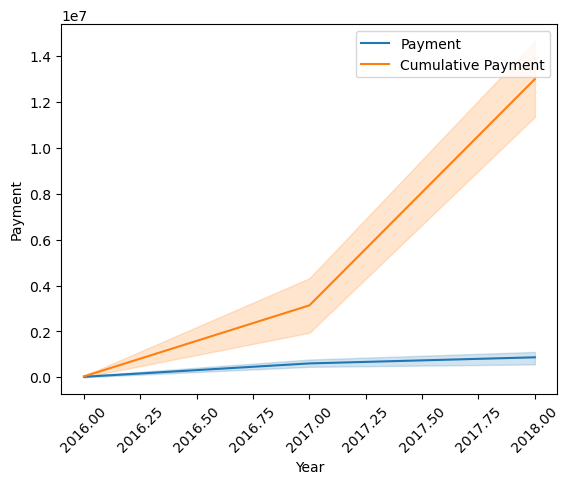

In [32]:
# Execute the SQL query
query = """ 
SELECT years, 
       months, payment,
       SUM(payment) OVER (ORDER BY years, months) AS cumulative_payment
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS years, 
           MONTH(orders.order_purchase_timestamp) AS months,
           ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS a;
"""

cur.execute(query)
data = cur.fetchall()

# Create the DataFrame
df = pd.DataFrame(data, columns=["Year", "Month", "Payment", "Cumulative Payment"])

# Plot the data
sns.lineplot(x="Year", y="Payment", data=df, label='Payment')
sns.lineplot(x="Year", y="Cumulative Payment", data=df, label='Cumulative Payment')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Calculate the year-over-year growth rate of total sales.

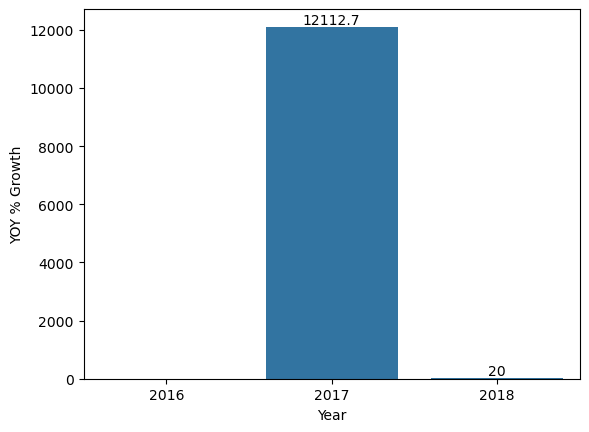

In [51]:
query = """
WITH a AS (
    SELECT YEAR(orders.order_purchase_timestamp) AS years, 
           ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
    ORDER BY years
)
SELECT years, 
       ROUND(((payment - LAG(payment, 1) OVER(ORDER BY years)) / LAG(payment, 1) OVER(ORDER BY years)) * 100, 2) AS yoy_growth
FROM a
"""

# Execute the query and fetch the data
cur.execute(query)
data = cur.fetchall()

# Create the DataFrame
df = pd.DataFrame(data, columns=["Year", "YOY % Growth"])

# Create the bar plot
ax = sns.barplot(data=df, x="Year", y="YOY % Growth")
ax.bar_label(ax.containers[0])

# Display the plot
plt.show()


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [50]:
query = """
WITH a AS (
    SELECT customers.customer_id, 
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),

b AS (
    SELECT a.customer_id, 
           COUNT(DISTINCT orders.order_purchase_timestamp) AS order_count
    FROM a 
    JOIN orders ON orders.customer_id = a.customer_id
    WHERE orders.order_purchase_timestamp > a.first_order
      AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)

SELECT 
    100 * (COUNT(DISTINCT a.customer_id) / NULLIF(COUNT(DISTINCT b.customer_id), 0)) AS retention_rate
FROM a 
LEFT JOIN b ON a.customer_id = b.customer_id;

"""

# Execute the query and fetch the data
cur.execute(query)
data = cur.fetchall()
data

[(None,)]

**Since there were no retained customers, the resulting value is `None`.**

## Identify the top 3 customers who spent the most money in each year.

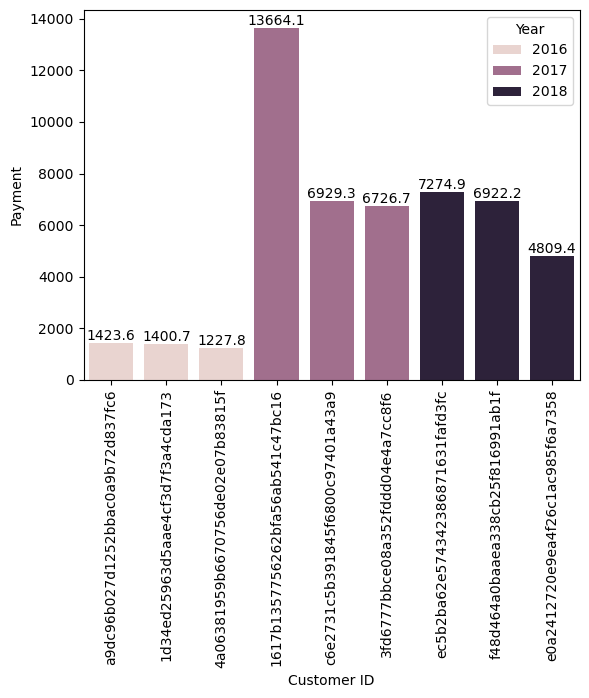

In [63]:
query = """
SELECT years, customer_id, round(payment,1), d_rank 
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years, 
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (PARTITION BY YEAR(orders.order_purchase_timestamp)
                           ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY years, orders.customer_id
) AS a
WHERE d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Year", "Customer ID", "Payment", "Rank"])

ax = sns.barplot(data = df, x = "Customer ID", y = "Payment", hue = "Year")
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()